In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import timeit

### <font color='068090'>Simple convolution example</font>

In [ ]:
img = np.array([
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
    [1,1,1,1,-1,-1,-1],
])

In [ ]:
plt.imshow(img)

In [ ]:
W = np.array([
    [1, 0, -1], 
    [1, 0, -1], 
    [1, 0, -1]
])

In [ ]:
n = img.shape[0]
f = W.shape[0]
p = 0
s = 1
a = int((n+2*p-f)/s)+1

In [ ]:
y = np.zeros((a,a))

In [ ]:
for i in range(a):
    for j in range(a):
        y[i, j] = np.sum((img[i:i+f,j:j+f]*W))

In [ ]:
plt.imshow(y)

### <font color='068090'> Basic convolution layer forwardprop and backprop </font> 

#### Defining test

Defining input parameters

In [ ]:
m = 12
nh_0 = 64
nw_0 = 64
nc_0 = 3

In [ ]:
A0 = np.random.rand(m, nh_0, nw_0, nc_0)

Defining layer parameters

In [ ]:
from meik.utils.activations import relu, drelu

In [ ]:
fh = 5
fw = 7
nc = 10
s = 1
ph = 0
pw = 0
g = relu
dg = drelu

In [ ]:
nh = int((nh_0+2*ph-fh)/s)+1
nw = int((nw_0+2*pw-fw)/s)+1

Defining layer variables

In [ ]:
W = np.random.rand(fh, fw, nc_0, nc)

In [ ]:
b = np.random.rand(1, 1, 1, nc)

#### Computing forwardprop

In [ ]:
def forwardprop_v1(A_0, params):
    
    W, b, g, fh, fw, s, nh, nw, nc = params
    
    Z = np.zeros((m,nh,nw,nc))
    
    for i in range(nh):
        
        for j in range(nw):
            
            axes = tuple(i for i in range(1,len(Z.shape)))
            
            # Note on np.newaxis: extension of A dimension such that it is copied along the additional axis for multiplication
            Z[:, i, j, :] = np.sum((A_0[:,i*s:i*s+fh,j*s:j*s+fw,:,np.newaxis]*W), axis=axes)
            
    Z += b
    
    A = g(Z)

    return A

In [ ]:
A = forwardprop_v1(A0, [W, b, g, fh, fw, s, nh, nw, nc])

In [ ]:
timeit('forwardprop_v1(A0, [W, b, g, fh, fw, s, nh, nw, nc])', globals=globals(), number=10)/10

#### Computing backprop v1

In [ ]:
def backprop_v1(dA0, params):
    
    A, A0, W, dg = params
    
    m, nh_0, nw_0, nc_0 = A0.shape
    fh, fw, _, nc = W.shape
    
    dZ = dg(A)*dA0
    
    axes = tuple(i for i in range(0,len(dZ.shape)-1))
    db = 1./m * np.sum(dZ, axis=axes, keepdims=True)
    
    dW = np.zeros(W.shape)
    dA = np.zeros(A0.shape)
    
    for i in range(nh):

        for j in range(nw):

                A0_ = A0[:,i:i+fh,j:j+fw,:,np.newaxis]
                dZ_ = dZ[:,i,j,:][:,np.newaxis,np.newaxis,np.newaxis,:] 

                dW += np.sum(A0_*dZ_, axis=0, keepdims=False)

                W_ = W[np.newaxis]

                dA[:,i:i+fh,j:j+fw,:] += np.sum(W_*dZ_, axis=4, keepdims=False)

    dW *= 1./m
    
    return dA, dW, db

In [ ]:
dA0 = np.random.random(A.shape)

In [ ]:
dA, dW, db = backprop_v1(dA0, [A, A0, W, dg])

In [ ]:
timeit('backprop_v1(dA0, [A, A0, W, dg])', globals=globals(), number=10)/10

#### Convolution as matrix multiplication

An easier to understand implementation using matrix multiplication: http://cs231n.github.io/convolutional-networks/

In [ ]:
def im2col(A, fh, fw, s):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    out = np.zeros((m, fh*fw*nc_0, nh*nw))
    
    for i in range(nh):

        for j in range(nw):

               out[:, :, i*nw+j] = A[:,i*s:i*s+fh,j*s:j*s+fw,:].reshape(m, fh*fw*nc_0)
                
    return out

In [ ]:
def forwardprop_col(A0, params):
    
    W, b, g, fh, fw, s, nh, nw, nc = params
    
    A0_col = im2col(A0, fh, fw, s)
    
    m, _, _, nc_0 = A0.shape
    
    W = W.reshape(fh*fw*nc_0,nc).T
    
    Z = np.zeros((m, nh, nw, nc))
    
    for i in range(m):
        
        Z[i] = np.dot(W,A0_col[i]).T.reshape(1, nh, nw, nc)
        
    Z += b
    
    A = g(Z)
    
    return A
    

In [ ]:
A0_col = im2col(A0, fh, fw, s)

In [ ]:
A = forwardprop_col(A0, [W, b, g, fh, fw, s, nh, nw, nc])

Checking if it produces the same result as previous implementation:

In [ ]:
np.all(A_1 == A)

Testing the speed:

In [ ]:
timeit('forwardprop_col(A0, [W, b, g, fh, fw, s, nh, nw, nc])', globals=globals(), number=100)/100

A point to note is that im2col seems to take the majority of the computation. Can this be done more efficiently?

In [ ]:
timeit('im2col(A0, fh, fw, s)', globals=globals(), number=100)/100

### <font color='068090'> An attempt to improve im2col speed </font> 

####  2D case

Idea from: https://stackoverflow.com/questions/30109068/implement-matlabs-im2col-sliding-in-python/30110497

Generating a 2D test case

In [ ]:
V = np.arange(15)[:,None]*5+np.arange(5)
f = 3
s = 1

In [ ]:
def im2col_2d(A, f, s):
    
    nh_0, nw_0 = A.shape
    
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    out = []
    
    for i in range(nh):

        for j in range(nw):

               out.append(A[i*s:i*s+f,j*s:j*s+f].flatten())
                
    return np.array(out).flatten()

In [ ]:
def im2col_2d_idxs_bc(nh_0, nw_0, f, s):
      
    nh = int((nh_0-f)/s)+1
    nw = int((nw_0-f)/s)+1
    
    # generating indexes of filter window on flattened 2D image
    # for location (0,0) in the output image
    filter_idxs = np.arange(f)[:,np.newaxis]*nw_0 + np.arange(f)

    # generating the index in the flattened 2D image where the filter starts
    # for each location in the output image
    offset_idxs = (np.arange(nh)*s*nw_0)[:,np.newaxis] + np.arange(nw)*s
    
    # generating the full set of indices by generating a set of filter indices
    # for each start location 
    idxs = (offset_idxs.flatten()[:,np.newaxis]+filter_idxs.flatten()).flatten()
    
    return idxs

In [ ]:
def im2col_2d_bc(A, f, s):
    
    nh_0, nw_0 = A.shape
    
    idxs = im2col_2d_idxs_bc(nh_0, nw_0, f, s)
    
    return A.flatten()[idxs]

Checking the two implementations produce the same result

In [ ]:
np.all(im2col_2d_bc(V,f,s) == im2col_2d(V,f,s))

Timing the functions

In [ ]:
timeit('im2col_2d(V, f, s)', globals=globals(), number=10000)/10000

In [ ]:
timeit('im2col_2d_idxs_bc(V.shape[0], V.shape[1], f, s)', globals=globals(), number=10000)/10000

In [ ]:
timeit('im2col_2d_bc(V, f, s)', globals=globals(), number=10000)/10000

Strategy of using broadcasting is faster according to this simple test. It seems reasonable to extend to 3D. But its important to note that the generation of the indexes takes a significant portion of the time and this only needs to be done once per layer at initialization!

#### Extending to 3D

Generating test case

In [ ]:
m = 2
nh_0 = 4
nw_0 = 6
nc_0 = 3

In [ ]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)

In [ ]:
# each channel contains a 2D feature image
A0[0,:,:,0]

In [ ]:
fh = 2
fw = 3
nc = 5
s = 1

In [ ]:
nh = int((nh_0-fh)/s)+1
nw = int((nw_0-fw)/s)+1

In [ ]:
def im2col_3d_idxs_bc(nh_0, nw_0, nc_0, fh, fw, s):
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    filter_idxs = ((np.arange(fh)[:,None]*nw_0*nc_0 + np.arange(fw)*nc_0)[:,:,None] + np.arange(nc_0)).flatten()
    
    offset_idxs = ((np.arange(nh)*s*nw_0*nc_0)[:,None] + np.arange(nw)*s*nc_0).flatten()
    
    idxs = offset_idxs[:,None] + filter_idxs
    
    return idxs

In [ ]:
def im2col_bc(A,fh,fw,s,idxs=None):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    if type(idxs)==type(None):
        idxs = im2col_3d_idxs_bc(nh_0, nw_0, nc_0, fh, fw, s)
    
    # Note: arranging colums where channels are appended to each other pixel by pixel
    return np.swapaxes(A0.reshape(m,nh_0*nw_0*nc_0)[:,idxs].reshape(m,nh*nw,fh*fw*nc_0),1,2)

In [ ]:
# arranging colums where each 2D image is flattened then appended channel by channel
# np.swapaxes(A0.reshape(m,nh_0*nw_0,nc_0)[0,idxs,:].reshape(nw*nh,f*f,nc_0),1,2).reshape(nw*nh,f*f*nc_0).T

Testing that the two methods produce the same result

In [ ]:
A0_col = im2col(A0,fh,fw,s)

In [ ]:
A0_col_bc = im2col_bc(A0,fh,fw,s)

In [ ]:
np.all(A0_col == A0_col_bc)

Testing speed of new implementation

In [ ]:
timeit('im2col(A0,fh,fw,s)', globals=globals(), number=10000)/10000

In [ ]:
timeit('im2col_bc(A0,fh,fw,s)', globals=globals(), number=10000)/10000

The speed improvement is not significant when indexes have to be generated. However, what about in the case that they have already been calculated?

In [ ]:
idxs = im2col_3d_idxs_bc(nh_0, nw_0, nc_0, fh, fw, s)

In [ ]:
timeit('im2col_bc(A0, fh, fw, s, idxs=idxs)', globals=globals(), number=100000)/100000

We experience a fair speedup with the new method!

### <font color='068090'> Convolution backprop as matrix multiplication </font>  

In [ ]:
from meik.utils.activations import relu, drelu
from meik.utils.convolution import im2col_idxs

In [ ]:
m = 2
nh_0 = 4
nw_0 = 6
nc_0 = 3

In [ ]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)

In [ ]:
fh = 2
fw = 3
nc = 5
s = 1

In [ ]:
nh = int((nh_0-fh)/s)+1
nw = int((nw_0-fw)/s)+1

In [ ]:
W = np.random.rand(fh, fw, nc_0, nc)
b = np.random.rand(1, 1, 1, nc)

In [ ]:
g = relu
dg = drelu

In [ ]:
A = forwardprop(A0, [W, b, g, fh, fw, s, nh, nw, nc])

In [ ]:
dA0 = np.arange(m*nh*nw*nc).reshape(m, nh, nw, nc)

In [ ]:
idxs = im2col_idxs(nh_0, nw_0, nc_0, fh, fw, s)

In [ ]:
def backprop_col(dA0, params):
    
    A, A0, A0_col, W, dg, idxs = params
    
    m, nh_0, nw_0, nc_0 = A0.shape
    fh, fw, _, nc = W.shape
    
    nh = int((nh_0-fh)/s)+1
    nw = int((nw_0-fw)/s)+1
    
    dZ = dA0*dg(A)
            
    W_ = W.reshape(fh*fw*nc_0, nc)
    dZ_ = np.swapaxes(dZ.reshape(m, nh*nw, nc),1,2)
    
    dW_ = np.zeros(W_.shape)
    dA_col = np.zeros(A0_col.shape)
    
    axes = tuple(np.arange(len(dZ.shape)-1))
    db = 1./m * np.sum(dZ, axis=axes, keepdims=True)
    
    for i in range(m):
        
        dA_col[i] = np.dot(W_, dZ_[i])
        dW_ += np.dot(A0_col[i], dZ_[i].T)
    
    dW_ *= 1./m

    dA = np.zeros(A0.shape).flatten()
    
    # col2im_v1: doesn't seem efficient since we have to loop -> issue of no accumulation with fancy indexing
    #    for i in range(nw*nh):
    #        dA[:, idxs[i,:]] += dA_col[:,:,i]
 
    # col2im_v2: using np.ufunc.at
    # generating indices for flattening across training examples
    idxs_m = ((np.arange((m),dtype=np.int8)*nh_0*nw_0*nc_0)[:,None] + idxs.flatten()).flatten()
    
    # flattening where features (f x f x nc_0), then training examples, are concatenated
    dA_col = np.swapaxes(dA_col,1,2).flatten()
    
    # adds dA_col to the correct location in the input volume 
    # by accumulating the result for elements that are indexed multiple times
    np.add.at(dA, idxs_m, dA_col)
    
    dA = dA.reshape(A0.shape)
    
    return dA, dW_.reshape(fh,fw,nc_0, nc), db

In [ ]:
dA, dW, db = backprop_col(dA0, [A, A0, A0_col, W, dg, idxs])

In [ ]:
dA1, dW1, db1 = backprop_v1(dA0, [A, A0, W, dg])

Checking the two backprop methods produce the same result

In [ ]:
np.all((dA - dA1) < 1e-12)

Timing the two versions

In [ ]:
timeit('backprop_col(dA0, [A, A0, A0_col, W, dg, idxs])', globals=globals(), number=10000)/10000

In [ ]:
timeit('backprop_v1(dA0, [A, A0, W, dg])', globals=globals(), number=10000)/10000

### <font color='068090'> Padding </font>  

In [ ]:
m, nh_0, nw_0, nc_0 = (2, 5, 5, 3)

In [ ]:
fh, fw, s = (3,3,1)

In [ ]:
a = ((np.arange(m)[:,None]*nh_0*nw_0*nc_0 + np.arange(nh_0))[:,:,None]*nw_0*nc_0 + np.arange(nw_0))[:,:,:,None]*nc_0 + np.arange(nc_0)

In [ ]:
# 'Same'
ph = (nh_0*(s-1)+fh-s)/2
pw = (nw_0*(s-1)+fw-s)/2

# For 'same' padding ensure the filter size and stride are appropriate: e.g. (nw*(s-1)+fw-s)/2 == 0
assert (ph%1 == 0.0 and pw%1 == 0.0), "Ensure (nw*(s-1)+fw-s)/2 == 0"
ph = int(ph)
pw = int(pw)

In [ ]:
def padding(A, ph, pw):

    m, nh_0, nw_0, nc_0 = A.shape

    A_pad = np.zeros((m, nh_0 + 2*ph, nw_0 + 2*pw, nc_0))

    A_pad[:, ph:-ph, pw:-pw, :] = A

    return A_pad

In [ ]:
def depadding(A, ph, pw):
    
    m, nh_0, nw_0, nc_0 = A.shape
    
    A_depad = np.zeros((m, nh_0 - 2*ph, nw_0 - 2*pw, nc_0))
    
    A_depad = A[:, ph:-ph, pw:-pw, :]
    
    return A_depad

In [ ]:
a_pad = padding(a, ph, pw)

In [ ]:
a_depad = depadding(a_pad, ph, pw)

In [ ]:
np.all(a_depad == a)

### <font color='068090'> Convolution layer class </font>  

Putting it all together

In [ ]:
import numpy as np
from meik.layers import Convolution3D

In [ ]:
m = 12
nh_0 = 64
nw_0 = 64
nc_0 = 1

In [ ]:
A0 = np.random.rand(m, nh_0, nw_0, nc_0)

In [ ]:
kernel = (4, 7)
nc = 10
s = 3
padding = 'valid'

In [ ]:
# filters, kernel_size = (3,3), stride = 1, padding = 'valid', inputs = None, units = None, activation = None, initialization = None, init_params = None
L1 = Convolution3D(nc, kernel, stride = s, padding = padding, activation = 'relu', inputs = (nh_0, nw_0, nc_0))

In [ ]:
L1.init(0, (nh_0, nw_0, nc_0))

Testing forwardprop

In [ ]:
A1 = L1.forwardprop(A0)

Testing backprop

In [ ]:
dA, idxs_m = L1.backprop(A1)

### <font color='068090'> Pooling </font>  

In [ ]:
import numpy as np
from meik.utils.convolution import im2col

In [ ]:
m = 2
nh_0 = 4
nw_0 = 4
nc_0 = 3

In [ ]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)
#A0 = np.random.rand(m, nh_0, nw_0, nc_0)

In [ ]:
fh = 2
fw = 2
s = 2

#### Pooling

In [ ]:
def pool(A0, fh, fw, s, mode='max'):
    
    m, _, _, nc_0 = A0.shape
    
    nh = (nh_0-fh)/s+1
    nw = (nw_0-fw)/s+1
    
    assert(nh%1 == 0.0 and nw%1 == 0.0), "Ensure the combination of input size, filter size and stride produce an integer output shape: e.g. ((nw_0+2*pw-fw)/s+1)%1 == 0"

    nh = int(nh)
    nw = int(nw)
    
    A0_col = im2col(A0, fh, fw, s).reshape(m, fh*fw, nc_0, nh*nw)
    
    if mode=='max':
        
        A_pool = np.max(A0_col, axis=1)
        idx = np.argmax(A0_col, axis=1)
        
    elif mode=='avg':
        
        A_pool = np.mean(A0_col, axis=1)
        idx = None
    
    return np.swapaxes(A_pool,1,2).reshape(m, nh, nw, nc_0), idx

In [ ]:
A_pool_max, max_idxs = pool(A0, fh, fw, s, mode='max')

In [ ]:
A_pool_avg, _ = pool(A0, fh, fw, s, mode='avg')

#### Un-pooling

In [ ]:
from meik.utils.convolution import im2col_idxs

def unpool(A_pool, fh, fw, s, max_idxs = None, mode='max'):
    
    m, nh, nw, nc_0 = A_pool.shape
    
    nh_0 = (nh - 1)*s + fh
    nw_0 = (nw - 1)*s + fw
    
    # obtaining indices of im2col elements in flattened input
    idxs = im2col_idxs(nh_0, nw_0, nc_0, fh, fw, s)
    idxs_m = ((np.arange(m)*nh_0*nw_0*nc_0)[:,None] + idxs.flatten()).flatten()
    
    # empty target
    A = np.zeros((m*nh_0*nw_0*nc_0)).flatten()
    
    if mode == 'max':

        # converting indices from argmax format to indices of idxs_m
        max_idxs = np.swapaxes(max_idxs, 1, 2) # rearranging for channels as last dimension
        max_idxs = max_idxs*nc_0 + np.arange(nc_0)[None,None,:] # incrementing by channel
        max_idxs += np.arange(nh*nw)[None,:,None]*fh*fw*nc_0 # incrementing by filter offset
        max_idxs += np.arange(m)[:,None,None]*nh*nw*fh*fw*nc_0 # incrementing by training example
        max_idxs = max_idxs.flatten()

        # obtaining indices of pooling max elements in flattened input
        idxs = idxs_m[max_idxs]
        
        # obtaining values
        vals = A_pool.flatten()
        
    elif mode == 'avg':
        
        # obtaining indices of pooling max elements in flattened input
        idxs = idxs_m
        
        # obtaining values
        vals = 1./(fh*fw) * (np.swapaxes(A_pool[:,:,:,:,None] + np.arange(fh*fw)*0,3,4)).flatten()
        
    # 0btaining de-pooled A
    np.add.at(A, idxs, vals)
        
    return A.reshape(m, nh_0, nw_0, nc_0)
    

In [ ]:
A_unpooled_max = unpool(A_pool_max, fh, fw, s, max_idxs = max_idxs, mode='max')

In [ ]:
A_unpooled_avg = unpool(A_pool_avg, fh, fw, s, mode='avg')

#### Inspecting results

In [ ]:
A0[0,:,:,0]

For max

In [ ]:
A_pool_max[0,:,:,0]

In [ ]:
A_unpooled_max[0,:,:,0]

For avg

In [ ]:
A_pool_avg[0,:,:,0]

In [ ]:
A_unpooled_avg[0,:,:,0]

#### Pooling layer class

In [ ]:
from meik.layers import Pool

#### Testing pooling layer

For max

In [ ]:
P1 = Pool()

In [ ]:
P1.init(0, (nh_0,nw_0,nc_0))

In [ ]:
A_pool = P1.forwardprop(A0)

In [ ]:
A_unpool = P1.backprop(A_pool)

In [ ]:
A_pool[0,:,:,0]

In [ ]:
A_unpool[0,:,:,0]

For avg

In [ ]:
P2 = Pool(mode='avg')

In [ ]:
P2.init(0, (nh_0,nw_0,nc_0))

In [ ]:
A_pool_avg = P2.forwardprop(A0)

In [ ]:
A_unpool_avg = P2.backprop(A_pool_avg)

In [ ]:
A_pool_avg[0,:,:,0]

In [ ]:
A_unpool_avg[0,:,:,0]

### <font color='068090'> Flatten layer </font>  

In [4]:
import numpy as np
from meik.layers import Flatten

In [5]:
m = 2
nh_0 = 4
nw_0 = 4
nc_0 = 3

In [6]:
A0 = np.arange(m*nh_0*nw_0*nc_0).reshape(m, nh_0, nw_0, nc_0)

In [7]:
F1 = Flatten()

In [8]:
F1.init(0, (nh_0,nw_0,nc_0))

In [9]:
A = F1.forwardprop(A0)

In [10]:
A0_f = F1.backprop(F1.forwardprop(A0))

In [11]:
np.all(A0_f == A0)

True

### <font color='068090'> MNIST </font>  

Obtaining dataset

In [12]:
from keras.datasets import mnist

Using TensorFlow backend.


In [13]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

One-hot encoding labels

In [14]:
def one_hot_encode(y):
    
    shape = tuple(list(y.shape)+[np.max(y)+1])
    l = np.zeros(shape)
    
    l[np.arange(l.shape[0]),y] = 1
    
    return l

In [15]:
Y_train = one_hot_encode(y_train).T

In [16]:
Y_test = one_hot_encode(y_test).T

### MNIST With fully connected

Flattening inputs

In [17]:
m, h, w = x_train.shape

In [18]:
X_train = x_train.reshape(m, h*w).T

In [19]:
n, h, w = x_test.shape

In [20]:
X_test = x_test.reshape(n, h*w).T

Setting up model

In [21]:
from meik.models import Sequential
from meik.layers import Layer, Dense, Dropout, Batch_norm

In [22]:
model = Sequential()

In [23]:
model.add(Dense(units=64, activation='relu', inputs=28*28))
model.add(Batch_norm())
model.add(Dense(units=32, activation='relu'))
model.add(Batch_norm())
model.add(Dense(units=16, activation='relu'))
model.add(Batch_norm())
model.add(Dense(units=10, activation='softmax'))

In [24]:
from meik import optimizers
optimizer = optimizers.Adam()

In [25]:
metrics = ['accuracy', 'binary_crossentropy', 'confusion_matrix']

In [26]:
model.build(loss='categorical_crossentropy', optimizer=optimizer, eval_metrics=metrics)

In [28]:
model.train(X_train, Y_train, batch_size=64, epochs=1, verbose=1)

Epoch 1/1 - loss_tot: 0.2737 - reg_loss: 0.0000 - categorical_crossentropy: 0.2737
------------ Final performance ------------

Epoch 1/1 - loss_tot: 0.2737 - reg_loss: 0.0000 - categorical_crossentropy: 0.2737


In [29]:
from meik.utils.misc import plot_training_loss

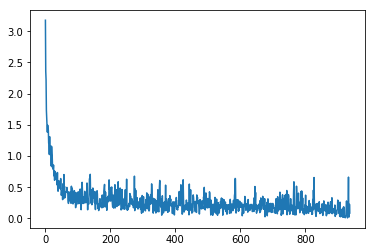

In [30]:
plot_training_loss(model, loss=model.params['loss'], mode='batch')

In [31]:
score = model.evaluate(X_test,Y_test)

### MNIST with Convolution3D

Setting up data

In [34]:
X_train = x_train
Y_train = one_hot_encode(y_train)

In [35]:
X_test = x_test
Y_test = one_hot_encode(y_test)

In [39]:
m, h, w = X_train.shape

Setting up model

In [36]:
from meik.models import Sequential
from meik.layers import Convolution3D, Pool, Flatten, Dense

In [42]:
model = Sequential()

In [43]:
model.add(Convolution3D(32, (3,3), stride = 1, padding = 'valid', activation = 'relu', inputs = (h,w,1)))
model.add(Convolution3D(64, (3,3), stride = 1, padding = 'valid', activation = 'relu'))
model.add(Pool(kernel_size=(2,2), stride=2, mode='max'))
model.add(Flatten())
model.add(Dense(units=10, activation='softmax'))

In [46]:
from meik import optimizers
optimizer = optimizers.Adam()

In [47]:
metrics = ['accuracy', 'binary_crossentropy', 'confusion_matrix']

In [48]:
model.build(loss='categorical_crossentropy', optimizer=optimizer, eval_metrics=metrics)

In [49]:
model.train(X_train, Y_train, batch_size=64, epochs=1, verbose=1)

AssertionError: Make sure the input is 2 dimensional e.g. np.shape(X) = (s1, s2) not (s1,)